# Solving a travelling salesman problem (TSP) using GUROBI
### 221B Baker Street: The Master Detective Game (a.k.a. Scotland Yard board game)

The 221B Baker Street: The Master Detective Game (a.k.a. Scotland Yard board game) is a board game from 1975 **[\[2\]](https://boardgamegeek.com/boardgame/1275/221b-baker-street-master-detective-game)** where you play as the famous detective Sherlock Holmes trying to solve intriguing cases. Starting from Sherlock Holmes' house, you need to visit diferent locations in London picking up clues and evidences in order to solve the case given to you by the Scotland Yard. After figuring out the answers to the particular mystery, the player must return to the starting point at the 221B Baker Street and say out loud the solution.

Problem characteristics:

* Start and return to the 221B Baker street;
* Locations contain clues/evidences but not every one will;
* The number of squares between each pair of locations is the distance (cost) between them;
* There is one special location, the Carriage Depot. From there, we can use a wagon to take you anywhere else in the map at no cost.


<img src="./data/sy_board.png" alt="drawing" style="width:450px;"/>
<!-- ![board](./data/sy_board.png){width: 10px} -->

This problem can be modeled and solved as a TSP-like.

## Requisites

* GUROBI solver (9 or an early version) and gurobipy. Academics can obtain it via this [link](https://www.gurobi.com/downloads/gurobi-optimizer-eula/#Reg "Gurobi's register page").

### TSP with Miller-Tucker-Zemlin (MTZ) constraints **[\[1\]](https://dl.acm.org/doi/10.1145/321043.321046)**

Let $G = (V, E)$ be a directed weighted complete graph, where $V$ ($|V| = n$) is the set of vertices and $E$ is the set of edges. For each edge $\{i, j\} \in E$, let $d_{ij} \geq 0$ be the weighted associated with edge $(i, j)$, i.e., the distance between vertices $i$ and $j$. Decision variables $x_{ij}$, also known as routing variables, define whether the edge $(i, j)$ belongs to the route or not. Integer variables $u_i$ are the counter variables of the MTZ constraints. So the TSP-MTZ can be defined as follows:

$$
\begin{align}
\min & \sum_\limits{(i, j) \in E} d_{ij}x_{ij} & \\
& \text{subject to} \\
& \sum\limits_{i = 1, i \neq j}^n x_{ij} = 1, & \forall j \in V, \\
& \sum\limits_{j = 1, j \neq i}^n x_{ij} = 1, & \forall i \in V, \\
& u_j \geq u_i + 1 - n(1 - x_{ij}), & 2 \leq i \neq j \leq n, \\
& 1 \leq u_i \leq n - 1, & 2 \leq i \leq n, \\
& x_{ij} \in \{0, 1\}, & \forall i, j \in V, \\
& u_i \in \mathbb{Z}, & i = 2, \dots, n
\end{align}
$$



In [1]:
import csv
import sys

import numpy
import gurobipy as gp
from gurobipy import GRB
from matplotlib import pyplot as plt

# Import helper function
sys.path.insert(0, './print_solution.py')
from print_solution import *

#### Read data

In [2]:
# Distance matrix
dist = numpy.array([row[1:] for row in list(csv.reader(open("./data/scotland_yard_adj_mtx.csv", "r"), delimiter=","))[1:]]).astype("int")

print(dist)

# Number of vertices
n = len(dist)

[[ 0  7 10 17 13 29 17 25 20 17 19 23 33 31 24]
 [ 7  0 15 16 12 28 22 24 15 11 12 16 31 25 17]
 [10 15  0  9  7 21 15 17 12 16 19 23 25 23 24]
 [17 16  9  0  8 14  8 10 11 15 20 24 18 16 24]
 [13 12  7  8  0 18 14 14  9 11 14 18 22 20 19]
 [29 28 21 14 18  0 16  6  7 22 17 13 10  4 12]
 [17 22 15  8 14 16  0 12 17 21 26 27 20 18 26]
 [25 24 17 10 14  6 12  0 11 21 21 17 10  8 16]
 [20 15 12 11  9  7 17 11  0  6 11  8 15  5  7]
 [17 11 16 15 11 22 21 21  6  0  7 11 26 20 12]
 [19 12 19 20 14 17 26 21 11  7  0  6 21 15  7]
 [23 16 23 24 18 13 27 17  8 11  6  0 17 11  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [31 25 23 16 20  4 18  8  5 20 15 11 12  0 10]
 [24 17 24 24 19 12 26 16  7 12  7  3 11 10  0]]


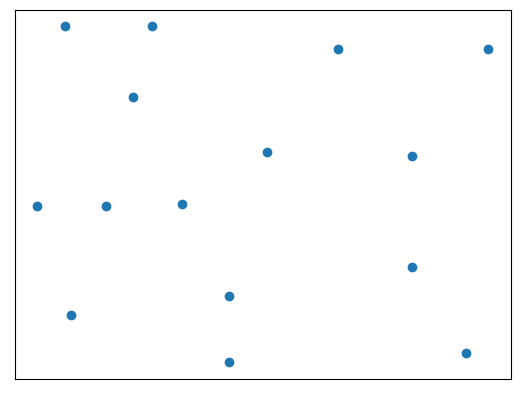

In [4]:
# Vertices coordinates (x,y)
coords = numpy.array(list(csv.reader(open("./data/coords.csv", "r"), delimiter=","))).astype("float")

x1, y1 = coords.T
plt.scatter(x1, y1)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

#### Building the TSP-MTZ model using Gurobi's API

In [6]:
# Model TSP with Miller-Tucker-Zemlin (MTZ) constraints
tspMtzModel = gp.Model("tsp_mtz")

# Add routing variables x_ij
x = tspMtzModel.addVars(n, n, obj=dist, vtype=GRB.BINARY, name="x")

# Add MTZ counter variables u_i
u = tspMtzModel.addVars(n, lb=1, ub=n-1, vtype=GRB.INTEGER, name="u")

#### Adding constraints

In [8]:
# In-edges constraints
tspMtzModel.addConstrs((gp.quicksum(x[i, j] for i in range(n) if i != j) == 1 
                                            for j in range(n)), name="c1_")

# Out-edges constraints
tspMtzModel.addConstrs((gp.quicksum(x[i, j] for j in range(n) if j != i) == 1 
                                            for i in range(n)), name="c2_")

# MTZ constraints
tspMtzModel.addConstrs((u[j] >= u[i] + 1 - n * (1 - x[i, j]) for i in range(1, n)
                                                             for j in range(1, n)
                                                             if i != j), name="c3_")
tspMtzModel.update() # Workaround to avoid GRB's noisy output

#### Solving the model

In [9]:
# Solve the model
tspMtzModel.optimize()
# Print route(s)
printSolution(tspMtzModel, x, n)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 424 rows, 240 columns and 1932 nonzeros
Model fingerprint: 0xf50ccf55
Variable types: 0 continuous, 240 integer (225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e+00, 3e+01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 212 rows and 16 columns
Presolve time: 0.01s
Presolved: 212 rows, 224 columns, 966 nonzeros
Variable types: 0 continuous, 224 integer (210 binary)
Found heuristic solution: objective 256.0000000

Root relaxation: objective 8.885714e+01, 53 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   88.85714    0   17  256.00000   88.85714  65.3%     -    0s
H    0     0                     

#### Plotting the solution

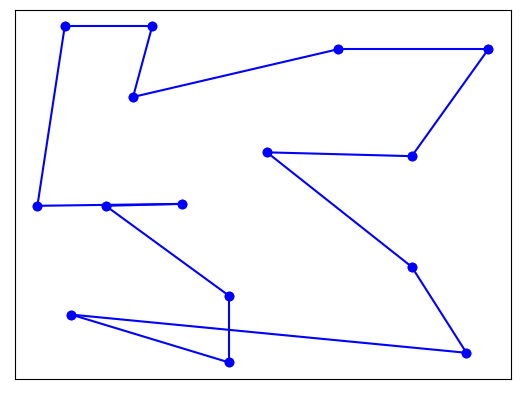

In [10]:
for i in range(n): 
    for j in range(n):
        if x[i, j].X >= 0.0001: 
                plt.plot([x1[i], x1[j]], [y1[i], y1[j]], color='blue', marker='o')
            
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

## Some (lazy) modifications

In the board game, however, visiting all vertices is not mandatory. Instead, we could visit only $p$ out of $n$ vertices if we believe we already collected enough evidences from the locations. So we can modify (in a dumb way) our TSP-MTZ to handle this by adding new binary variables $y_i$. These variables control whether vertex $i$ is visited or not. So the new TSP-like problem can be defined as follows:

$$
\begin{align}
\min & \sum_\limits{(i, j) \in E} d_{ij}x_{ij} & \\
& \text{subject to} \\
& \sum\limits_{i = 1}^n y_i = p, & \\
& \sum\limits_{i = 1, i \neq j}^n x_{ij} = y_j, & \forall j \in V, \\
& \sum\limits_{j = 1, j \neq i}^n x_{ij} = y_i, & \forall i \in V, \\
& u_j \geq u_i + 1 - n(1 - x_{ij}), & 2 \leq i \neq j \leq n, \\
& 1 \leq u_i \leq n - 1, & 2 \leq i \leq n, \\
& y_1 = 1, & \\
& y_i, x_{ij} \in \{0, 1\}, & \forall i, j \in V, \\
& u_i \in \mathbb{Z}, & i = 2, \dots, n
\end{align}
$$

#### Building the new model

In [18]:
# Number of vertices to visit ([2, 15])
p = 3

# Modified model TSP-MTZ
tspMtzSyModel = gp.Model("tsp_mtz_sy")

# Add visiting variables y_i
y = tspMtzSyModel.addVars(n, vtype=GRB.BINARY, name="y")

# Add routing variables x_ij
x = tspMtzSyModel.addVars(n, n, obj=dist, vtype=GRB.BINARY, name="x")

# Add MTZ counter variables u_i
u = tspMtzSyModel.addVars(n, lb=1, ub=n-1, vtype=GRB.INTEGER, name="u")

#### Adding constraints

In [19]:
# Visit p vertices constraints
tspMtzSyModel.addConstr(gp.quicksum(y[i] for i in range(n)) == p, "c0_")

# In-edges constraints
tspMtzSyModel.addConstrs((gp.quicksum(x[i, j] for i in range(n) if i != j) == y[j] 
                                              for j in range(n)), name="c1_")

# Out-edges constraints
tspMtzSyModel.addConstrs((gp.quicksum(x[i, j] for j in range(n) if j != i) == y[i]
                                              for i in range(n)), name="c2_")

# MTZ constraints
tspMtzSyModel.addConstrs((u[j] >= u[i] + 1 - n * (1 - x[i, j]) for i in range(1, n)
                                                             for j in range(1, n)
                                                             if i != j), name="c3_")
tspMtzSyModel.addConstr(y[0] == 1, "c4_")
tspMtzSyModel.update() # Workaround to silence GRB's output

#### Solving the new model

In [20]:
# Solve the model
tspMtzSyModel.optimize()
# Print route(s)
printSolution(tspMtzSyModel, x, n)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 214 rows, 255 columns and 1012 nonzeros
Model fingerprint: 0x4a52e641
Variable types: 0 continuous, 255 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e+00, 3e+01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 64.0000000
Presolve removed 31 rows and 47 columns
Presolve time: 0.02s
Presolved: 183 rows, 208 columns, 858 nonzeros
Variable types: 0 continuous, 208 integer (194 binary)

Root relaxation: objective 1.700000e+01, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   17.00000    0    4   64.00000   17.00000  73.4%     -    0s
H    0     0                      4

#### Plotting the new solution

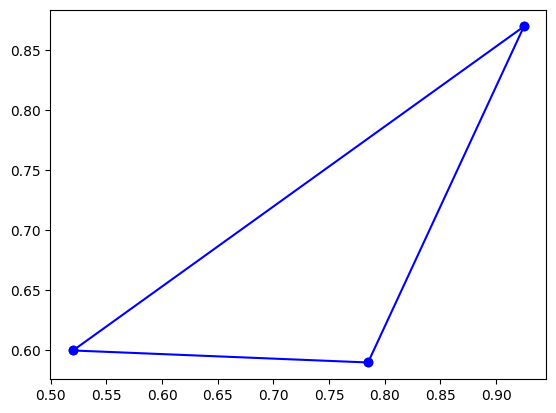

In [22]:
for i in range(n): 
    for j in range(n):
        if x[i, j].X >= 0.0001: 
                plt.plot([x1[i], x1[j]], [y1[i], y1[j]], color='blue', marker='o')
            
plt.show()

### References

**[\[1\] C. E. Miller and A. W. Tucker. Integer Programming Formulation of Traveling Salesman Problems, Journal of the ACM, Volume 7, Issue 4, 1960, pp 326-329](https://dl.acm.org/doi/10.1145/321043.321046)**

**[\[2\] https://boardgamegeek.com/boardgame/1275/221b-baker-street-master-detective-game](https://boardgamegeek.com/boardgame/1275/221b-baker-street-master-detective-game)**